# Ames Housing Step-by-step - Exercise 7 - Solution

## Use SHAP values to explain how features contribute to Sale Price prediction

Pieter Overdevest  
2024-02-09

For suggestions/questions regarding this notebook, please contact
[Pieter Overdevest](https://www.linkedin.com/in/pieteroverdevest/)
(pieter@innovatewithdata.nl).

### Introduction

In this exercise we predict the sale price by using a Random Forest model - as example of a blackbox model - with k-fold cross-validation and grid search on a small set of hyperparameters. The latter part was added to show you another example how to apply cross-validation and hyperparameter optimization.

### How to work with this Jupyter Notebook yourself?

- Get a copy of the repository (or 'repo') [discover-projects/ames-housing](https://github.com/EAISI/discover-projects/tree/main/ames-housing) from EAISI's GitHub site. This can be done by either cloning the repo or simply downloading the zip-file. Both options are explained in this Youtube video by [Coderama](https://www.youtube.com/watch?v=EhxPBMQFCaI). This exercise builds on the six exercises presented in the Ames Housing case in this repo.

- Copy this notebook in the folder 'ames-housing\\' to your own project folder.


### Use of ChatGPT, Cody, Copilot, ..

In case you want to use platforms like ChatGPT, Cody, or Copilot, here are some suggestions to enter:

* How to import random forrest regression model in python?
* What hyperparameters do I have access to in this model?
* Can you suggest a dictionary with some common ranges to use with these hyperparameters?
* How to use this model in conjunction with gridsearchcv?

Of course, these questions are already quite specific and when you start your questions might be more generic, like "How do I do check the performance on a range of hyperparameters". These examples show that also as you develop your knowledge, the likes of ChatGPT remain a good source for suggesting snippets of code.


### Two routes to proceed with this exercise

(1) You proceed with the notebook(s) that you developed for exercises 1-6. You copy the code snippets below to your notebook(s). Then, you use your own processed data.

(2) You proceed with this Jupyter Notebook. Copy 'dc-ames-housing-pieter-exercise-5-6.pkl' to the same folder where you store this notebook. You can find this so-called 'pickled' file in the folder '\example-solutions\ames-housing-pieter\data\' in repo [machine-learning-with-python-explainers](https://github.com/EAISI/machine-learning-with-python-explainers) on EAISI's GitHub site. Then, you load the pickled file in this notebook using the code below.

In [5]:
# Third party packages.
import pickle   # Save and load data
import shap     # Explain the model (SHAP)

# Import module.
from sklearn.ensemble           import RandomForestRegressor    # Random forest
from sklearn.model_selection    import GridSearchCV             # Grid search

# Pieter's utils package.
import utils_pieter as up

### Load objects from earlier exercises

In [6]:
with open('data/dc-ames-housing-pieter-exercise-5-6.pkl', 'rb') as pickle_file:
    dc_exercise_5_6 = pickle.load(pickle_file)

df_X_train_scaled = dc_exercise_5_6['df_X_train_scaled']
ps_y_log_train    = dc_exercise_5_6['ps_y_log_train']

### Exercise A - Construct a data frame holding the imputed numerical data of the Ames Housing data set (optionally, as a challenge, also include the one hot encoded neighborhoods). Perform a train/test split on the data frame you constructed. Since, the SHAP calculation are computer intensive, take the first 500 observations from the resulting training set (call it, `df_X_fraction`) and take the first 500 elements of the outcome variable from the training set (call it, `ps_y_fraction`).

In [7]:
# We take a fraction from the data to speed up the exercise. SHAP analysis are computer intensive.
df_X_fraction = df_X_train_scaled.iloc[0:500]
ps_y_fraction = ps_y_log_train[0:500]

### Exercise B - Run or copy/paste the content from the cell below to your notebook.

In [8]:
# Hyperparameter grid:
dc_hyperparameter_ranges = {

    'bootstrap':            [True,False],   # Do we bootstrap samples, or not.
    'max_depth':            [20],           # Maximum depth of each tree
    'max_features':         ['sqrt'],       # Number of variables to consider at each split
    'min_samples_leaf':     [4],            # Minimum number of samples required to be at a leaf node
    'min_samples_split':    [4],            # Minimum number of samples required to split an internal node
    'n_estimators':         [1000],         # Number of trees
    'random_state':         [42]            # Random state for reproducibility
}

# Perform a gridsearch on the random forest model:
gridsearch = GridSearchCV(
    estimator  = RandomForestRegressor(),
    param_grid = dc_hyperparameter_ranges,
    scoring    = 'neg_mean_squared_error',
    cv         = 5
)

# Use subset of training data to do a gridsearch on the random forest model:
gridsearch.fit(df_X_fraction, ps_y_fraction)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [20],
                         'max_features': ['sqrt'], 'min_samples_leaf': [4],
                         'min_samples_split': [4], 'n_estimators': [1000],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

### Exercise C - Show the value of the `best_params` attribute of the `gridsearch` object. What do the attributes `best_params_` and `best_estimator_` refer to? Assign the value of the `best_estimator_` attribute to a new object called, `best_model`.

The best hyperparameter set from the set given in `dc_hyperparameter_ranges` is captured in the attribute `best_params_`.

In [9]:
gridsearch.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 1000,
 'random_state': 42}

The best performing model is captured in the attribute `best_estimator_`. So, we do not need to rerun the model with the best parameters.

In [10]:
best_model = gridsearch.best_estimator_

The two cell below are extra (no exercise).

In [11]:
up.f_evaluate_results(
    ps_y_true = ps_y_fraction,
    ps_y_pred = gridsearch.predict(df_X_fraction)
)

Performance Metrics:
MAE:  0.049
MSE:  0.006
RMSE: 0.075


alt.LayerChart(...)

### Exercise D - Run or copy/paste the content from the cell below to your notebook.

In [12]:
# Initialize JavaScript visualization support for SHAP (SHapley Additive exPlanations) plots. 
shap.initjs()

# Create SHAP object.
explainer = shap.Explainer(best_model)

# Create SHAP values.
shap_values = explainer.shap_values(df_X_fraction)

### Exercise E - Waterfall Plot

We can use the `waterfall plot` to visualise the SHAP values for a single observation. Run or copy/paste the content from the cell below to your notebook. The questions refer to this code cell and to the resulting plot.

1 - Define an object to which you assign the index of the data point you want to explain the prediction for. Assign the value to your object such that you can explain the prediction for the second observation in the data.

2 - Replace '...' by the object name you defined above.

3 - What is the value for explainer.expected_value[0]?

4 - Run the cell.

5 - What do you conclude from the resulting figure? Use: (1) the answer from question 3 and (2) the prediction for the second observation in the data.

For reference see also [API Reference of SHAP module](https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html).

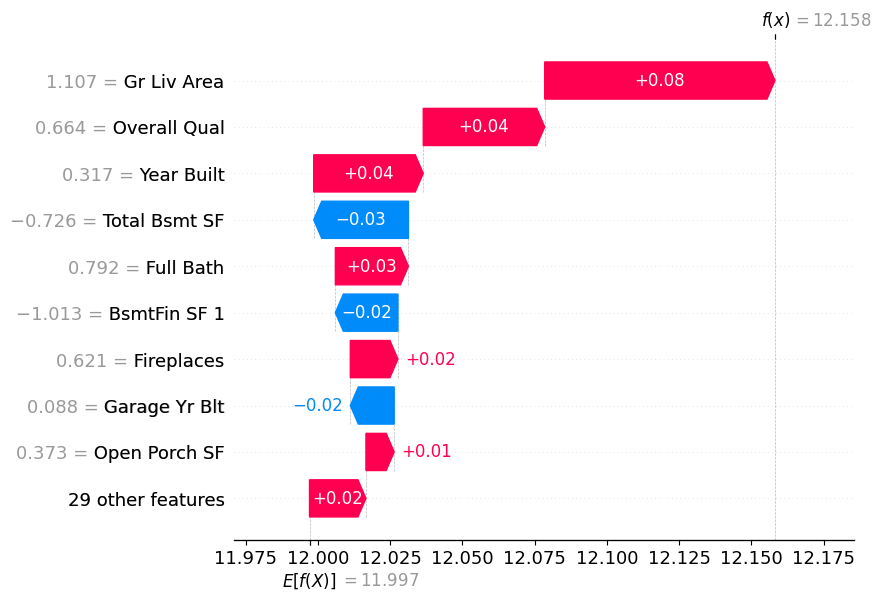

In [13]:
# Set index of data point you want to explain the prediction for.
n_index = 1

# Plot waterfall
shap.plots.waterfall(
    
    shap.Explanation(
        base_values   = explainer.expected_value[0], # Mean prediction for the entire training data.
        values        = shap_values[n_index],        # Subset of shap values.
        data          = df_X_fraction.iloc[n_index], # Subset of training data.
        feature_names = df_X_fraction.columns        # variable names.
))

In [14]:
# Prediction for the first observation:
print(f"Prediction for index {n_index}:     {round(gridsearch.predict(df_X_fraction)[n_index],3)}")

# Average of all predictions
print(f"Average of all predictions: {round(explainer.expected_value[0],3)}")

Prediction for index 1:     12.158
Average of all predictions: 11.997


In [15]:
# ANSWERS

# 1 - n_index = 1

# 2 - n_index

# 3 - It is the mean prediction for the entire training data. The answer should be a number; in my case it is 12.01.
# Though in individual cases the number may differ because we sampled the data differently.

# 5 - There will be a unique waterfall plot for every observation in our dataset. They can all be interpreted in
# the same way as above. In each case, the SHAP values tell us how the variables have contributed to the prediction
# when compared to the mean prediction. Large positive/negative values indicate that the variable had a significant
# impact on the model’s prediction. The prediction of 12.158 (in my case) can be constructed from the base value of
# 11.997 (mean prediction) and the contributions of the individual variables in the data, e.g., the scaled value of
# 1.107 for Overal Qual (in my case) adds 0.08 to the prediction for the log of the sales price.

### Exercise F - Force Plot

Another way to visualise the SHAP values is by using a force plot. You can think of this as a condensed waterfall plot. Run or copy/paste the content from the cell below to your notebook. The questions refer to this code cell and to the resulting plot.

1 - The force plot is a different representation of the waterfall plot. Apply the questions from exercise 1 to the cell below.

In [16]:
# Set index of data point you want to explain the prediction for. Write the answer to question a, below.
n_index = 1

# Plot Force Plot.
shap.plots.force(

    base_value    = explainer.expected_value[0], # Mean prediction for the entire training data.
    shap_values   = shap_values[n_index],          # SHAP values.
    features      = df_X_fraction.iloc[n_index],   # Training data.
    feature_names = df_X_fraction.columns        # variable names.
)

In [17]:
# ANSWERS

# See Exercise E.

### Exercise G - Stacked Force Plot

Waterfall and force plots are great for interpreting individual predictions. To understand how our model makes predictions in general we need to aggregate the SHAP values. One way to do this is by using a stacked-force plot. We can combine multiple force plots together to create a stacked force plot. We can pass all SHAP values in the force plot function, or we can limit it, as we will do here. Each individual force plot is now vertical and stacked side by side. Run or copy/paste the content from the cell below to your notebook. The questions refer to this code cell and to the resulting plot.

1 - Show the SHAP values for the first 10 observations.

2 - Set the dropdown at the top of the figure to 'original sample ordering' and to the left of the figure to 'f(x)'. Look up the SHAP values for the observation with index 1. How do they compare to the number in exercise E and F?

3 - Set the dropdown at the top of the figure to 'sample order by output value'. What do you observe?

4 - Set the dropdown at the top of the figure to 'Overall Qual' and to the left of the figure to 'Overall Qual effects'. What do you observe?

In [18]:
# Plot stacked force plot.
l_index = range(10)

shap.plots.force(
    
        base_value    = explainer.expected_value[0], # Mean prediction for the entire training data.
        shap_values   = shap_values[l_index],        # SHAP values.
        features      = df_X_fraction.iloc[l_index], # Training data.
        feature_names = df_X_fraction.columns        # variable names.
)

In [19]:
# ANSWERS

# 1 - l_index = range(10)

# 2 - They are the same.

# 3 - To the left we see a lot of red (positive SHAP values added to the average), resulting in the high predictions.
#     To the right we see a lot of blue (negative SHAP values subtracted from the average), resulting in the low predictions.
#     The prediction is on the interface between red and blue.

# 4 - We observe that as 'Overall Qual' increases, the SHAP value for Overall Qual increases.
#     In other words, houses with higher 'Overall qual' tend to have higher sales prices.

### Exercise H - Mean SHAP

This next plot will tell us which variables are most important. For each variable, we calculate the mean SHAP value across all observations. Specifically, we take the mean of the absolute values as we do not want positive and negative values to offset each other. There is one bar for each variable. Run or copy/paste the content from the cell below to your notebook. The questions refer to this code cell and to the resulting plot.

1 - Run the cell. What do you conclude from the resulting chart?

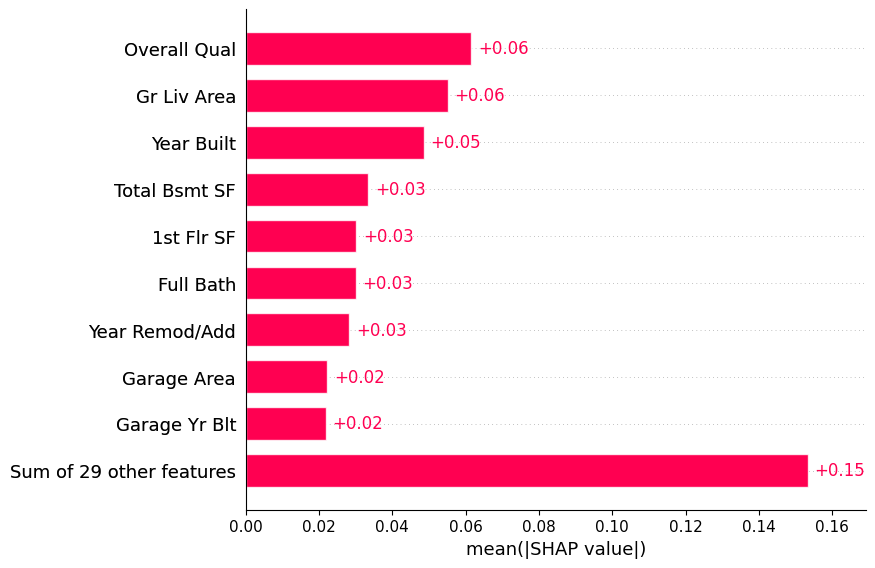

In [20]:
# Plot Mean SHAP.
shap.plots.bar(

    shap_values = shap.Explanation(
        base_values   = explainer.expected_value[0], # Mean prediction for the entire training data.
        values        = shap_values,                 # Subset of shap values.
        data          = df_X_fraction,               # Subset of training data.
        feature_names = df_X_fraction.columns        # variable names.
))



In [21]:
# ANSWERS

# 1 - Variables that have made large positive/negative contributions will have a large mean SHAP value.
# In other words, these are the variables that have had a significant impact on the model’s predictions.
# In this sense, this plot can be used in the same way as a variable importance plot.
# Overall Qual is the biggest explainer of the sale price, by far.

### Exercise I - Beeswarm Plot

Next, we have the single most useful plot. The beeswarm visualises all of the SHAP values. Run or copy/paste the content from the cell below to your notebook. The questions refer to this code cell and to the resulting plot.

1 - Run the cell. What do you conclude from the resulting chart?

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


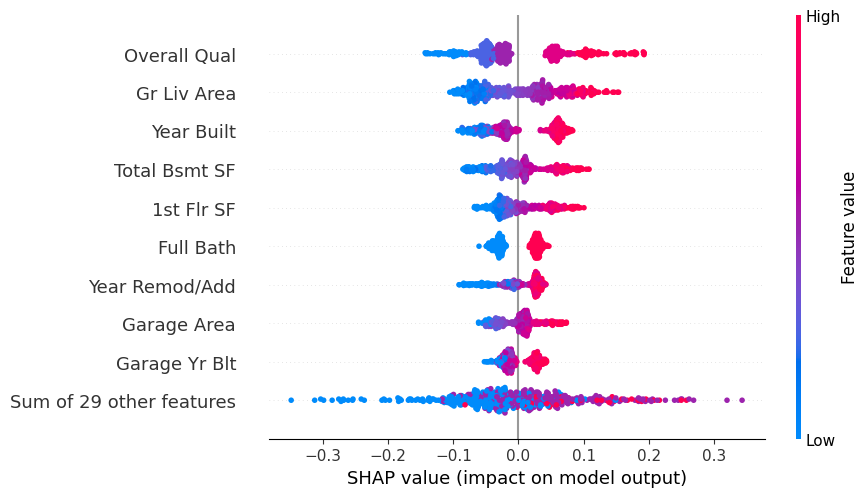

In [22]:
# Plot beeswarm plot.
shap.plots.beeswarm(
    
    shap.Explanation(
        base_values   = explainer.expected_value[0], # Mean prediction for the entire training data.
        values        = shap_values,                 # SHAP values.
        data          = df_X_fraction,               # Training data.
        feature_names = df_X_fraction.columns        # Variable names.
))

In [ ]:
# ANSWERS

# 1 - On the y-axis, the values are grouped by variable. For each variable, the colour of the points is
# determined by the variable value (i.e. low values are blue and high values are red).
# We can also start to understand the nature of these relationships. For 'Overall Qual', notice how as
# the variable value increases the SHAP values increase. We saw a similar relationship in the stacked
# force plot. It tells us that larger values for 'Overall Qual' will lead to a higher predicted Sale Price.
